# Wavefield Separation FWI sensitivity kernel
We compare sensitivity kernels in a half-space model with wavefield separation imaging conditions. Wavefield separation in the imaging condition can both enhance long wavelength FWI gradients (for FWI), and remove long wavelength backscattered energy (for RTM) and is implemented as a wavenumber filter in Kz following Faqi et. al. (2011).

### Workflow for the standard FWI imaging condition
The standard imaging condition will have short wavelengths in the FWI image, and also long wavelengths in the RTM image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Zero lag correlation of forward source wavefield `S` with backward receiver wavefield `R` at every point in the model: <br>
    `Image += S * R`

### Workflow for the wavefield separation FWI imaging condition
This will enhance long wavelengths in the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation at every point in the model: <br>
    `Image += Sup * Rup + Sdn * Rdn`

### Workflow for the wavefield separation RTM imaging condition
This will remove long wavelength backscattered energy from the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in water velocity model
1. Subtracting water velocity data from true data to remove direct arrival
1. Backproject the direct arrival removed true data
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation at every point in the model: <br>
    `Image += Sup * Rdn + Sdn * Rup`

### Note on conjugate symmetry
We can simplify further and only require two inverse Fourier transforms for each time step by following Faqi et. al. (2011). Please see the discussion between equation 9 and 10, this is what is implmented in `JetPackWaveFD`.

### Reference
* *An effective imaging condition for reverse-time migration using wavefield decomposition* 2011<br>
Faqi Liu, Guanquan Zhang, Scott A. Morton, and Jacques P. Leveille
https://library.seg.org/doi/full/10.1190/1.3533914

In [1]:
using PyPlot, Jets, WaveFD, JetPackWaveFD, Random, LinearAlgebra, Statistics, FFTW
using JUDI.TimeModeling, SegyIO, LinearAlgebra

## Acquisition geometry and global defaults
Note that JUDI requires y coordinates even tho in 2D

In [2]:
nz,nx = 150,600
dz,dx = 20.0f0,20.0f0
ntrec = 3001
dtrec = 0.002f0
dtmod = 0.002f0
fpeak = 5.0f0
nsponge = 80

extent = [0.0,dx*(nx-1),dz*(nz-1),0.0]

sz = dz * 1;
sy = 0.0f0;
sx = dx * div(nx,2);
rz = dz .* ones(Float32, nx);
ry = zeros(Float32, nx);
rx = dx .* Float32[0:(nx-1);];

@show sx,sy,sz

(sx, sy, sz) = (6000.0f0, 0.0f0, 20.0f0)


(6000.0f0, 0.0f0, 20.0f0)

## Setup the three models for COFII
* parameterized in velocity (m/s)
* true halfspace model with velocities 1500 m/s over 2000 m/s
* perturbed halfspace model with velocities 1505 m/s over 2000 m/s
* water velocity model at 1500 m/s

We make the perturbed model slightly faster in the upper half-space, which indicates that the gradients for FWI should be all positive.

In [3]:
z2 = 101

vtrue = 1500 .* ones(Float32,nz,nx);
vtrue[z2:end,:] .= 2000;

vpert = 1510 .* ones(Float32,nz,nx);
vpert[z2:end,:] .= 2000;

vwater = 1500 .* ones(Float32,nz,nx);

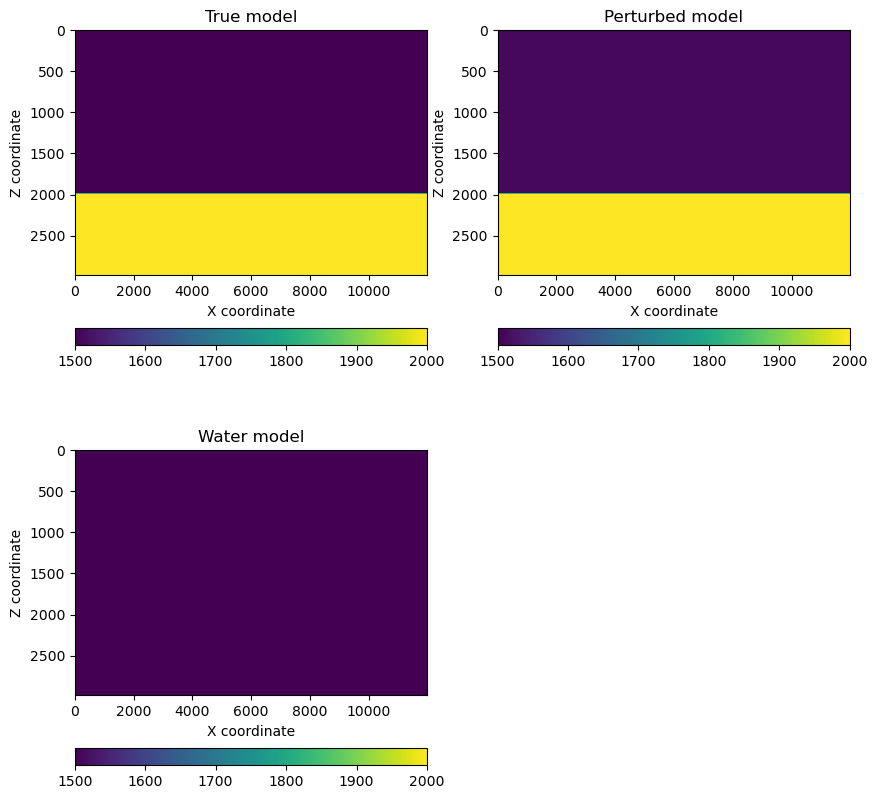

In [4]:
figure(figsize=(10,10))
vmin,vmax = extrema(vtrue)
subplot(2,2,1);imshow(vtrue,aspect="auto",extent=extent); title("True model"); clim(vmin,vmax);
colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(2,2,2);imshow(vpert,aspect="auto",extent=extent); title("Perturbed model"); clim(vmin,vmax)
colorbar(orientation="horizontal");
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(2,2,3);imshow(vwater,aspect="auto",extent=extent); title("Water model"); clim(vmin,vmax)
colorbar(orientation="horizontal");
xlabel("X coordinate"); ylabel("Z coordinate")

nothing

## Setup the three models for JUDI
* Parameterized in slowness squared, with units (s^2/km^2)
* Need to transpose the COFII dimensions

In [5]:
n = (nx, nz) # (nx,nz)
d = (dx, dz) # (dx,dz)
o = (0., 0.)
strue = (1000 ./ vtrue').^2
spert = (1000 ./ vpert').^2
swater = (1000 ./ vwater').^2

@show extrema(vtrue)
@show extrema(vpert)
@show extrema(vwater)

@show extrema(strue)
@show extrema(spert)
@show extrema(swater)

mtrue = Model(n, d, o, strue, nb=nsponge);
mpert = Model(n, d, o, spert, nb=nsponge);
mwater = Model(n, d, o, swater, nb=nsponge);

extrema(vtrue) = (1500.0f0, 2000.0f0)
extrema(vpert) = (1510.0f0, 2000.0f0)
extrema(vwater) = (1500.0f0, 1500.0f0)
extrema(strue) = (0.25f0, 0.44444448f0)
extrema(spert) = (0.25f0, 0.43857723f0)
extrema(swater) = (0.44444448f0, 0.44444448f0)


## Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [6]:
scratch = "/mnt/scratch"
@assert isdir(scratch)

## Make three operators for COFII
* Standard imaging condition 
* FWI imaging condition 
* RTM imaging condition 

In [7]:
compscale = 1e-1
qInterior = 100.0

Fstd = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    comptype = UInt32, compscale = compscale, qInterior = qInterior,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = nsponge,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=fpeak), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "standard");

Ffwi = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    comptype = UInt32, compscale = compscale, qInterior = qInterior,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = nsponge,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=fpeak), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "FWI");

Frtm = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    comptype = UInt32, compscale = compscale, qInterior = qInterior,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = nsponge,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=fpeak), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "RTM");

## Make three operators for JUDI
1. setup receiver geometry
1. setup source geometry
1. setup wavelet
1. setup info structure for linear operators
1. setup operators


In [8]:
# @set up receiver geometry
timeJUDI = 1000 * dtrec * (ntrec - 1)
dtJUDI = dtrec * 1000
nsrc = 1
recGeometry = Geometry(rx, ry, rz, dt=dtJUDI, t=timeJUDI, nsrc=nsrc);

# set up source geometry
xsrc = convertToCell([sx])
ysrc = convertToCell([sy])
zsrc = convertToCell([sz])
@show xsrc, ysrc, zsrc
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtJUDI, t=timeJUDI)

# setup wavelet
f0 = fpeak / 1000;
wavelet = ricker_wavelet(timeJUDI, dtJUDI, f0);
q = judiVector(srcGeometry, wavelet);

# Set up info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry, mtrue)
info = Info(prod(n), nsrc, ntComp)

# Write shots as segy files to disk
optSTD  = Options(optimal_checkpointing=false, isic=false, subsampling_factor=2, dt_comp=1.0)
optISIC = Options(optimal_checkpointing=false, isic=true, subsampling_factor=2, dt_comp=1.0)

# Setup operators
Pr = judiProjection(info, recGeometry)

FtrueSTD = judiModeling(info, mtrue; options=optSTD)
FpertSTD = judiModeling(info, mpert; options=optSTD)
FwaterSTD = judiModeling(info, mwater; options=optSTD)

FtrueISIC = judiModeling(info, mtrue; options=optISIC)
FpertISIC = judiModeling(info, mpert; options=optISIC)
FwaterISIC = judiModeling(info, mwater; options=optISIC)

Ps = judiProjection(info, srcGeometry);

(xsrc, ysrc, zsrc) = (Any[6000.0f0], Any[0.0f0], Any[20.0f0])


Operator `initdamp` run in 0.01 s


## Forward modeling for COFII
Generate data to be backprojected:
* FWI: backproject (d_pert - d_true)
* RTM: backproject (d_true - d_water)

In [9]:
dtrue = Fstd*vtrue;
dpert = Fstd*vpert;
dwater = Fstd*vwater;

rfwi = dpert .- dtrue
rrtm = dtrue .- dwater

@show extrema(dtrue);
@show extrema(dpert);
@show extrema(dwater);
@show extrema(rfwi);
@show extrema(rrtm);

extrema(dtrue) = (-88.17139f0, 168.91702f0)
extrema(dpert) = (-88.3315f0, 169.26738f0)
extrema(dwater) = (-88.17139f0, 168.91702f0)
extrema(rfwi) = (-2.5349238f0, 2.966791f0)
extrema(rrtm) = (-1.5591948f0, 3.2476854f0)


## Forward modeling for JUDI

In [10]:
dtrue_JUDI = Pr*FtrueSTD*adjoint(Ps)*q;
dpert_JUDI = Pr*FpertSTD*adjoint(Ps)*q;
dwater_JUDI = Pr*FwaterSTD*adjoint(Ps)*q;

rfwi_JUDI = dpert_JUDI .- dtrue_JUDI;
rrtm_JUDI = dtrue_JUDI .- dwater_JUDI;

@show extrema(dtrue_JUDI.data[1]);
@show extrema(dpert_JUDI.data[1]);
@show extrema(dwater_JUDI.data[1]);
@show extrema(rfwi_JUDI.data[1]);
@show extrema(rrtm_JUDI.data[1]);

extrema(dtrue_JUDI.data[1]) = (-88.526245f0, 169.37885f0)
extrema(dpert_JUDI.data[1]) = (-88.6859f0, 169.72809f0)
extrema(dwater_JUDI.data[1]) = (-88.52541f0, 169.38014f0)
extrema(rfwi_JUDI.data[1]) = (-4.850749f0, 5.187702f0)
extrema(rrtm_JUDI.data[1]) = (-2.8345187f0, 6.079169f0)


Operator `initdamp` run in 0.01 s
Operator `forward` run in 1.85 s
Operator `initdamp` run in 0.01 s
Operator `forward` run in 1.85 s
Operator `initdamp` run in 0.01 s
Operator `forward` run in 1.62 s


## Plot the generated data

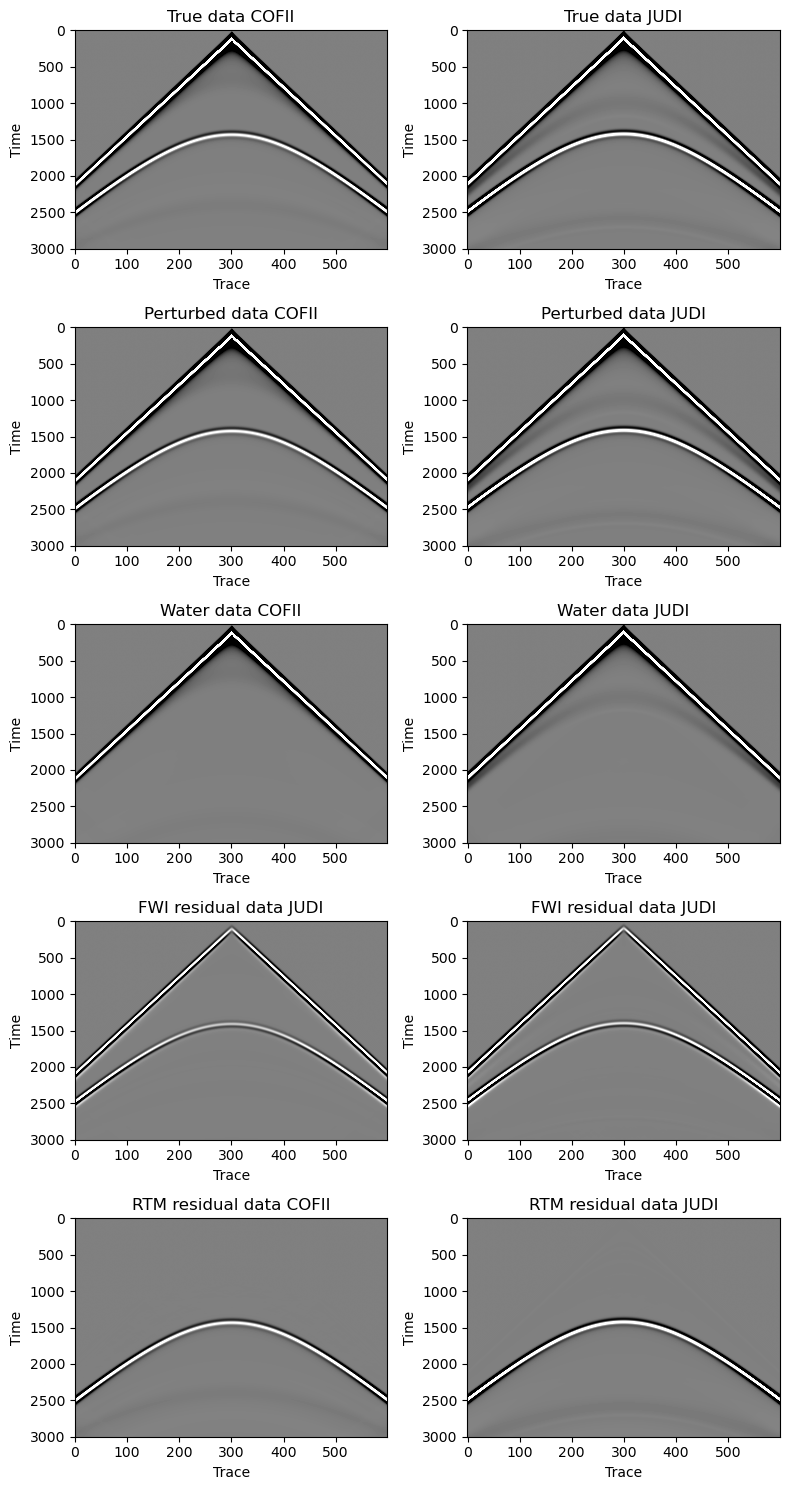

scale = 1.3949383571065395


In [11]:
scale = 2.5 / sqrt(norm(dtrue)^2 / length(dtrue))
@show scale

figure(figsize=(8,15)); clf()

subplot(5,2,1); imshow(scale .* dtrue,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("True data COFII")
xlabel("Trace"); ylabel("Time")
subplot(5,2,2); imshow(scale .* dtrue_JUDI.data[1],cmap="gray",aspect="auto",clim=[-1,+1]); 
title("True data JUDI")
xlabel("Trace"); ylabel("Time")

subplot(5,2,3); imshow(scale .* dpert,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Perturbed data COFII")
xlabel("Trace"); ylabel("Time")
subplot(5,2,4); imshow(scale .* dpert_JUDI.data[1],cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Perturbed data JUDI")
xlabel("Trace"); ylabel("Time")

subplot(5,2,5); imshow(scale .* dwater,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Water data COFII")
xlabel("Trace"); ylabel("Time")
subplot(5,2,6); imshow(scale .* dwater_JUDI.data[1],cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Water data JUDI")
xlabel("Trace"); ylabel("Time")

subplot(5,2,7); imshow(scale .* rfwi,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("FWI residual data JUDI")
xlabel("Trace"); ylabel("Time")
subplot(5,2,8); imshow(scale .* rfwi_JUDI.data[1],cmap="gray",aspect="auto",clim=[-1,+1]); 
title("FWI residual data JUDI")
xlabel("Trace"); ylabel("Time")

subplot(5,2,9); imshow(scale .* rrtm,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("RTM residual data COFII")
xlabel("Trace"); ylabel("Time")
subplot(5,2,10); imshow(scale .* rrtm_JUDI.data[1],cmap="gray",aspect="auto",clim=[-1,+1]); 
title("RTM residual data JUDI")
xlabel("Trace"); ylabel("Time")

tight_layout()
nothing

## Apply the three imaging conditions for COFII

In [12]:
Jstd = jacobian!(Fstd, vpert)
Jfwi = jacobian!(Ffwi, vpert)
Jrtm = jacobian!(Frtm, vpert)

fwi1 = Jstd' * rfwi;
fwi2 = Jfwi' * rfwi;
rtm1 = Jstd' * rrtm;
rtm2 = Jrtm' * rrtm;

fwi1 ./= maximum(abs,fwi1);
fwi2 ./= maximum(abs,fwi2);
rtm1 ./= maximum(abs,rtm1);
rtm2 ./= maximum(abs,rtm2);

## Apply the three imaging conditions for JUDI
* Note there is no *complement* to the inverse scattering imaging condition for FWI in JUDI like there is for the wavefield separation imaging condition in COFII, so there is no fwi2 here
* Note the JUDI models are parameterized in slowness^2, so we multiple by -1 for comparison with the COFII models parameterized in velocity

In [13]:
Jstd_JUDI = judiJacobian(Pr*FpertSTD*adjoint(Ps), q);
Jrtm_JUDI = judiJacobian(Pr*FpertISIC*adjoint(Ps), q);

fwi1_JUDI = Jstd_JUDI' * rfwi_JUDI;
rtm1_JUDI = Jstd_JUDI' * rrtm_JUDI;
rtm2_JUDI = Jrtm_JUDI' * rrtm_JUDI;

fwi1_JUDI = -1 .* reshape(fwi1_JUDI,nx,nz)';
rtm1_JUDI = -1 .* reshape(rtm1_JUDI,nx,nz)';
rtm2_JUDI = -1 .* reshape(rtm2_JUDI,nx,nz)';

fwi1_JUDI ./= maximum(abs,fwi1_JUDI);
rtm1_JUDI ./= maximum(abs,rtm1_JUDI);
rtm2_JUDI ./= maximum(abs,rtm2_JUDI);

Operator `initdamp` run in 0.01 s
Operator `forward` run in 2.32 s
Operator `gradient` run in 2.44 s
Operator `initdamp` run in 0.01 s
Operator `forward` run in 2.34 s
Operator `gradient` run in 2.48 s
Operator `initdamp` run in 0.01 s
Operator `forward` run in 2.34 s
Operator `gradient` run in 2.70 s


## Apply Laplacian high pass filter to the RTM images

In [14]:
using JetPack
L = JopLaplacian(JetSpace(Float32,nz,nx))

rtm1L = L * rtm1;
rtm1L_JUDI = L * rtm1_JUDI;

rtm1L ./= maximum(abs,rtm1L);
rtm1L_JUDI ./= maximum(abs,rtm1L_JUDI);

## Plot the results
* Because in the perturbed model the upper half-space is faster, we expect the gradient to be positive (red). 
* Note how the FWI wavefield separation enhances long wavelengths
* Note how the RTM wavefield separation removes long wavelength backscattered energy
* Note we plot -1 * JUDI result because parameterized in slowness, where COFII is parameterized in velocity 

### FWI images
* Compute normalization scaling in a window around the reflector depth

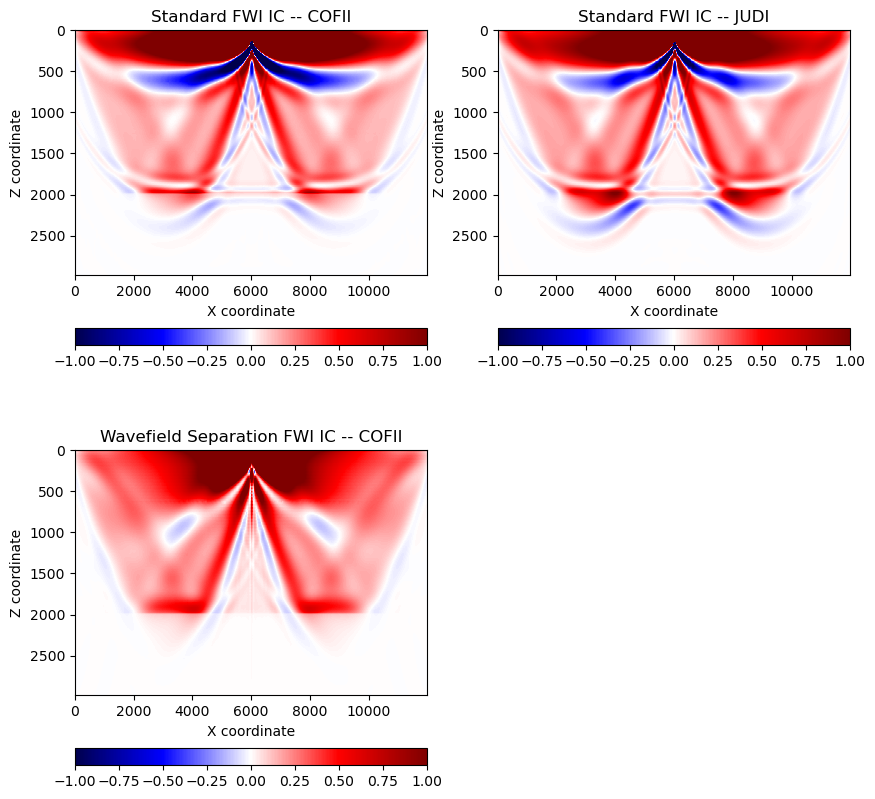

(scale_fwi1, scale_fwi2) = (55.07067584581509, 31.3491523650185)
(scale_rtm1, scale_rtm2) = (15.003179985763394, 8.417659447167035)
scale_rtm1L = 43.053017423022226

scale_fwi1_JUDI = 35.457973354422144
(scale_rtm1_JUDI, scale_rtm2_JUDI) = (9.19473136125774, 28.603498862564383)
scale_rtm1L_JUDI = 88.07435985140235


In [15]:
x2 = div(nx,2)
xsize = 80
zsize = 10

scale_fwi1  = 0.50 / maximum(abs, fwi1[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_fwi2  = 0.50 / maximum(abs, fwi2[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm1  = 0.50 / maximum(abs, rtm1[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm2  = 0.50 / maximum(abs, rtm2[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm1L = 0.50 / maximum(abs, rtm1L[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);

scale_fwi1_JUDI  = 0.50 / maximum(abs, fwi1_JUDI[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm1_JUDI  = 0.50 / maximum(abs, rtm1_JUDI[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm2_JUDI  = 0.50 / maximum(abs, rtm2_JUDI[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);
scale_rtm1L_JUDI = 0.50 / maximum(abs, rtm1L_JUDI[z2-zsize:z2+zsize,x2-xsize:x2+xsize]);

@show scale_fwi1,scale_fwi2
@show scale_rtm1,scale_rtm2
@show scale_rtm1L

write(stdout,"\n")
@show scale_fwi1_JUDI
@show scale_rtm1_JUDI,scale_rtm2_JUDI
@show scale_rtm1L_JUDI

figure(figsize=(10,10))

subplot(2,2,1); imshow(fwi1.*scale_fwi1,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Standard FWI IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(2,2,2); imshow(fwi1_JUDI.*scale_fwi1_JUDI,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Standard FWI IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(2,2,3); imshow(fwi2.*scale_fwi2,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Wavefield Separation FWI IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")

nothing

### RTM images
* Question, why does there appear to more low frequency in the JUDI result after applying the Laplacian?

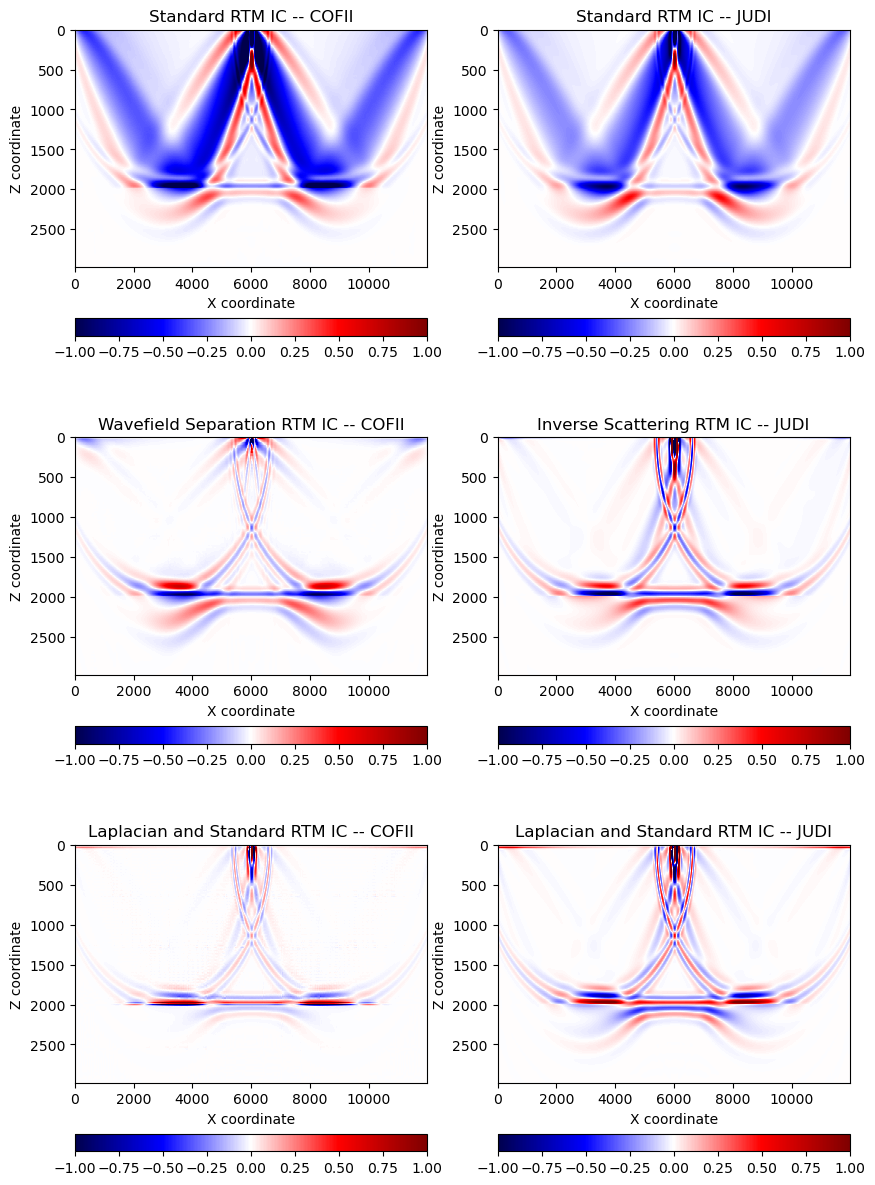

In [16]:
figure(figsize=(10,15))

subplot(3,2,1); imshow(rtm1.*scale_rtm1,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Standard RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(3,2,2); imshow(rtm1_JUDI.*scale_rtm1_JUDI,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Standard RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")

subplot(3,2,3); imshow(rtm2.*scale_rtm2,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Wavefield Separation RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(3,2,4); imshow(rtm2_JUDI.*scale_rtm2_JUDI,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Inverse Scattering RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")

subplot(3,2,5); imshow((rtm1L).*scale_rtm1L,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Laplacian and Standard RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")
subplot(3,2,6); imshow((rtm1L_JUDI).*scale_rtm1L_JUDI,aspect="auto",cmap="seismic",clim=[-1,1],extent=extent);
title("Laplacian and Standard RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Z coordinate")

nothing

## Kz Wavenumber analysis

In [17]:
using FFTW
nzmax = div(nz,5)

zfwi1_COFII = reverse(abs.(fft(fwi1,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zfwi2_COFII = reverse(abs.(fft(fwi2,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm1_COFII = reverse(abs.(fft(rtm1,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm2_COFII = reverse(abs.(fft(rtm2,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm1L_COFII = reverse(abs.(fft(rtm1L,1))[1:nzmax,:],dims=1) .+ eps(Float32)

max_fwi1_COFII = maximum(zfwi1_COFII);
max_fwi2_COFII = maximum(zfwi2_COFII);
max_rtm1_COFII = maximum(zrtm1_COFII);
max_rtm2_COFII = maximum(zrtm2_COFII);
max_rtm1L_COFII = maximum(zrtm1L_COFII);

db_fwi1_COFII = 20 .* log10.(zfwi1_COFII ./ max_fwi1_COFII);
db_fwi2_COFII = 20 .* log10.(zfwi2_COFII ./ max_fwi2_COFII);
db_rtm1_COFII = 20 .* log10.(zrtm1_COFII ./ max_rtm1_COFII);
db_rtm2_COFII = 20 .* log10.(zrtm2_COFII ./ max_rtm2_COFII);
db_rtm1L_COFII = 20 .* log10.(zrtm1L_COFII ./ max_rtm1L_COFII);

write(stdout,"\n")
@show extrema(db_fwi1_COFII);
@show extrema(db_fwi2_COFII);
@show extrema(db_rtm1_COFII);
@show extrema(db_rtm2_COFII);
@show extrema(db_rtm1L_COFII);

zfwi1_JUDI = reverse(abs.(fft(fwi1_JUDI,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm1_JUDI = reverse(abs.(fft(rtm1_JUDI,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm2_JUDI = reverse(abs.(fft(rtm2_JUDI,1))[1:nzmax,:],dims=1) .+ eps(Float32)
zrtm1L_JUDI = reverse(abs.(fft(rtm1L_JUDI,1))[1:nzmax,:],dims=1) .+ eps(Float32)

max_fwi1_JUDI = maximum(zfwi1_JUDI);
max_rtm1_JUDI = maximum(zrtm1_JUDI);
max_rtm2_JUDI = maximum(zrtm2_JUDI);
max_rtm1L_JUDI = maximum(zrtm1L_JUDI);

db_fwi1_JUDI = 20 .* log10.(zfwi1_JUDI ./ max_fwi1_JUDI);
db_rtm1_JUDI = 20 .* log10.(zrtm1_JUDI ./ max_rtm1_JUDI);
db_rtm2_JUDI = 20 .* log10.(zrtm2_JUDI ./ max_rtm2_JUDI);
db_rtm1L_JUDI = 20 .* log10.(zrtm1L_JUDI ./ max_rtm1L_JUDI);

write(stdout,"\n")
@show extrema(db_fwi1_JUDI);
@show extrema(db_rtm1_JUDI);
@show extrema(db_rtm2_JUDI);
@show extrema(db_rtm1L_JUDI);

fz = fftfreq(nz)[1:nzmax] ./ (2 * dx)
extent = [0.0,dx*(nx-1),extrema(fz)...]
write(stdout,"\n")
@show extent;


extrema(db_fwi1_COFII) = (-86.13716f0, 0.0f0)
extrema(db_fwi2_COFII) = (-70.41001f0, 0.0f0)
extrema(db_rtm1_COFII) = (-90.42445f0, 0.0f0)
extrema(db_rtm2_COFII) = (-77.414375f0, 0.0f0)
extrema(db_rtm1L_COFII) = (-141.21173f0, 0.0f0)

extrema(db_fwi1_JUDI) = (-71.02968f0, 0.0f0)
extrema(db_rtm1_JUDI) = (-88.84897f0, 0.0f0)
extrema(db_rtm2_JUDI) = (-87.69414f0, 0.0f0)
extrema(db_rtm1L_JUDI) = (-141.4228f0, 0.0f0)

extent = [0.0, 11980.0, 0.0, 0.004833333333333334]


### Kz Wavenumber plots for FWI

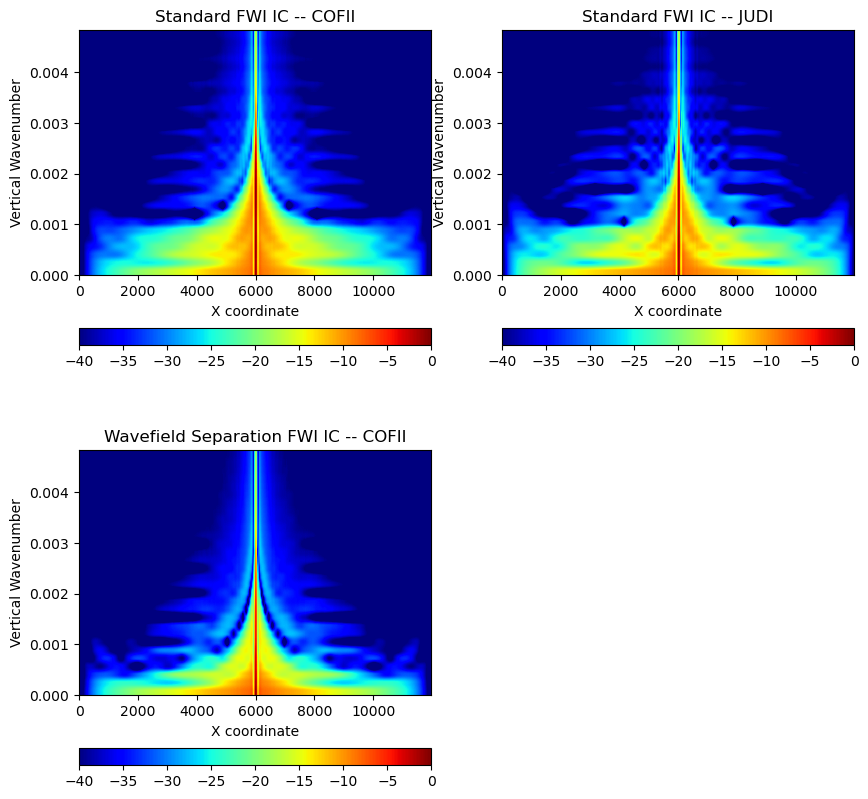

In [18]:
dbmin,dbmax = -40,0

figure(figsize=(10,10))

subplot(2,2,1); imshow(db_fwi1_COFII,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Standard FWI IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")
subplot(2,2,2); imshow(db_fwi1_JUDI,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Standard FWI IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")

subplot(2,2,3); imshow(db_fwi2_COFII,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Wavefield Separation FWI IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")

nothing

### Kz Wavenumber plots for FWI 1/4 and 1/2 across the model

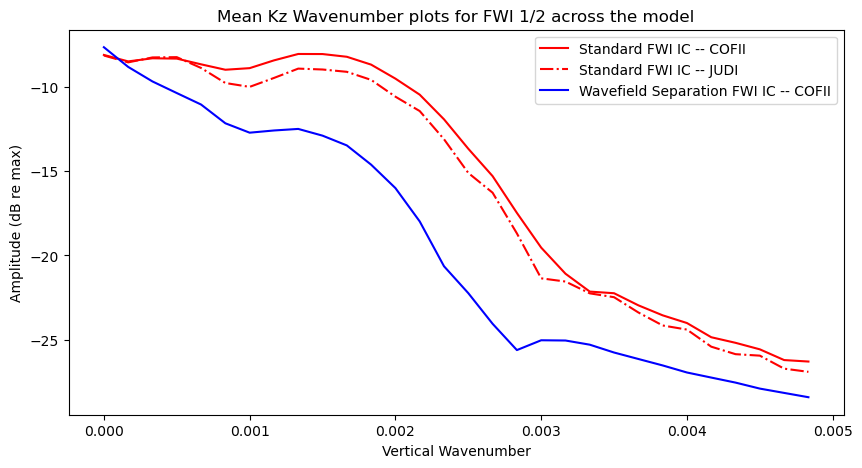

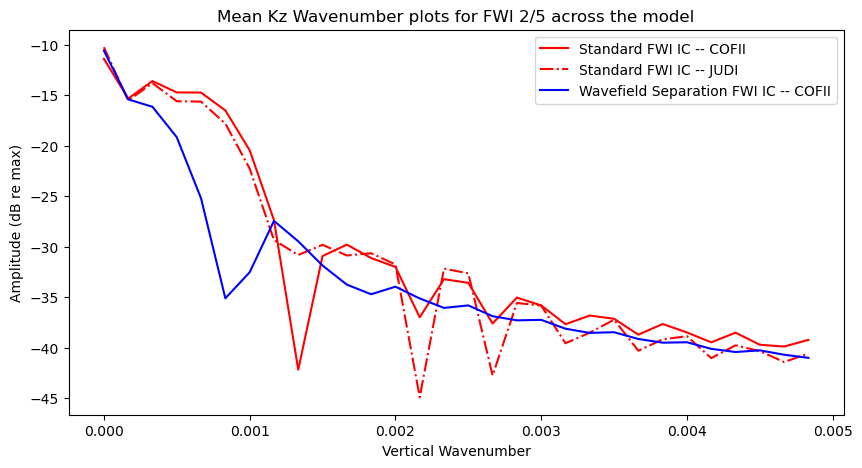

In [19]:
nmean = 5
x2 = div(nx,2)
x3 = 2*div(nx,5)

figure(figsize=(10,5))
plot(fz, reverse(mean(db_fwi1_COFII[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="solid",color="red",label="Standard FWI IC -- COFII");
plot(fz, reverse(mean(db_fwi1_JUDI[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="-.",color="red",label="Standard FWI IC -- JUDI");
plot(fz, reverse(mean(db_fwi2_COFII[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="solid",color="blue",label="Wavefield Separation FWI IC -- COFII");
title("Mean Kz Wavenumber plots for FWI 1/2 across the model")
xlabel("Vertical Wavenumber"); ylabel("Amplitude (dB re max)")
legend()

figure(figsize=(10,5))
plot(fz, reverse(mean(db_fwi1_COFII[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="solid",color="red",label="Standard FWI IC -- COFII");
plot(fz, reverse(mean(db_fwi1_JUDI[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="-.",color="red",label="Standard FWI IC -- JUDI");
plot(fz, reverse(mean(db_fwi2_COFII[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="solid",color="blue",label="Wavefield Separation FWI IC -- COFII");
title("Mean Kz Wavenumber plots for FWI 2/5 across the model")
xlabel("Vertical Wavenumber"); ylabel("Amplitude (dB re max)")
legend()

nothing

### Kz Wavenumber plots for RTM

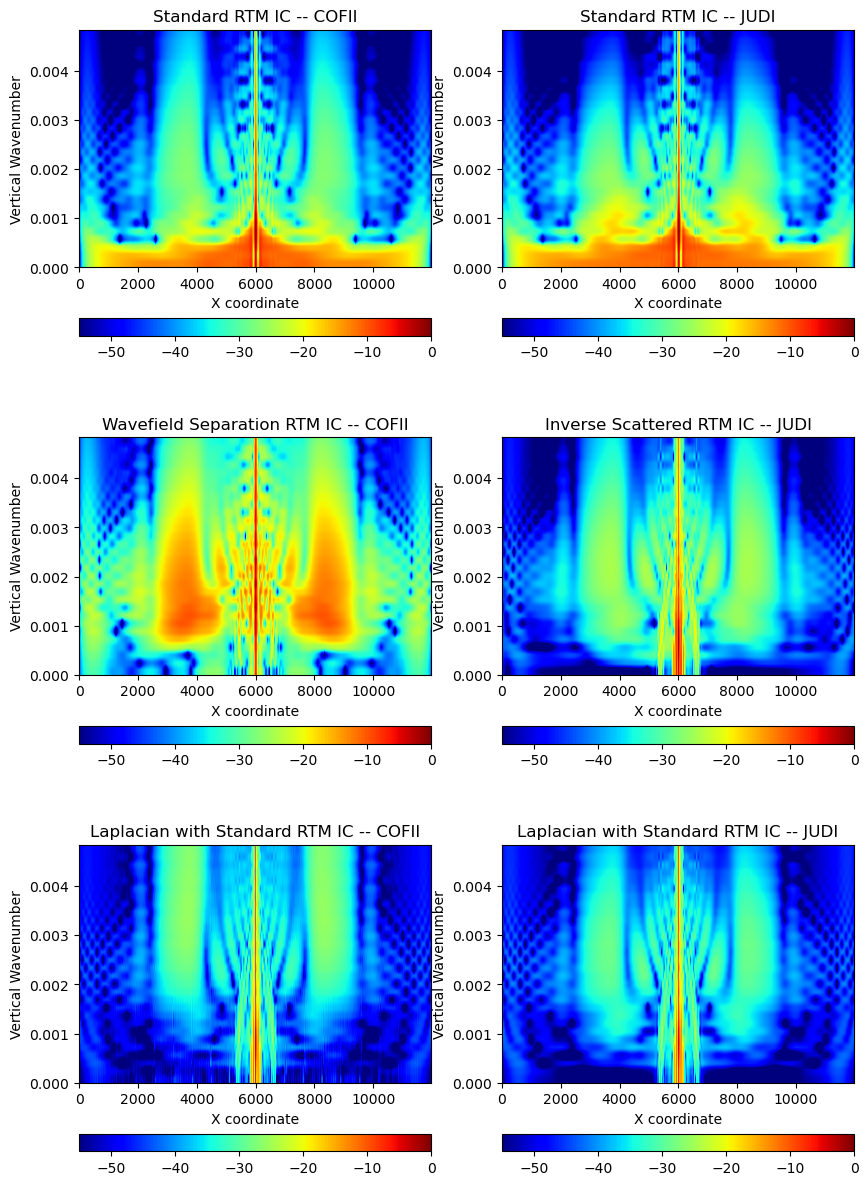

In [20]:
dbmin,dbmax = -55,0

figure(figsize=(10,15))

subplot(3,2,1); imshow(db_rtm1_COFII,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Standard RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")
subplot(3,2,2); imshow(db_rtm1_JUDI,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Standard RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")

subplot(3,2,3); imshow(db_rtm2_COFII,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Wavefield Separation RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")
subplot(3,2,4); imshow(db_rtm2_JUDI,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Inverse Scattered RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")

subplot(3,2,5); imshow(db_rtm1L_COFII,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Laplacian with Standard RTM IC -- COFII");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")
subplot(3,2,6); imshow(db_rtm1L_JUDI,aspect="auto",cmap="jet",clim=[dbmin,dbmax],extent=extent);
title("Laplacian with Standard RTM IC -- JUDI");colorbar(orientation="horizontal")
xlabel("X coordinate"); ylabel("Vertical Wavenumber")

nothing

### Kz Wavenumber plots for RTM directly below the source

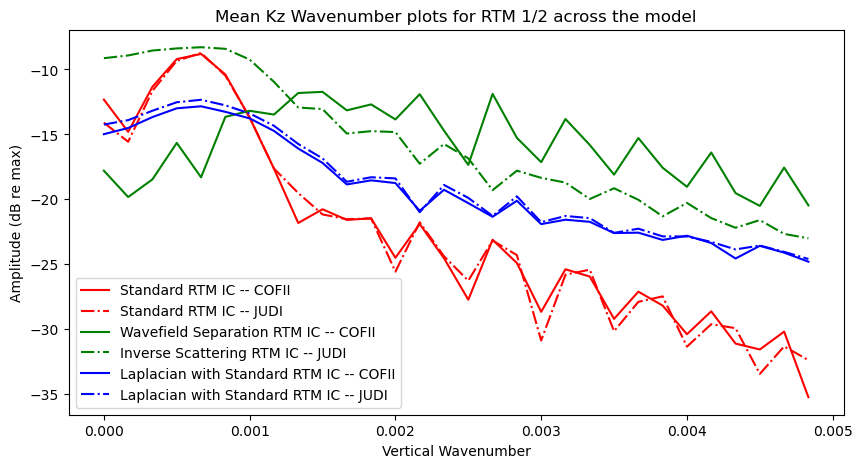

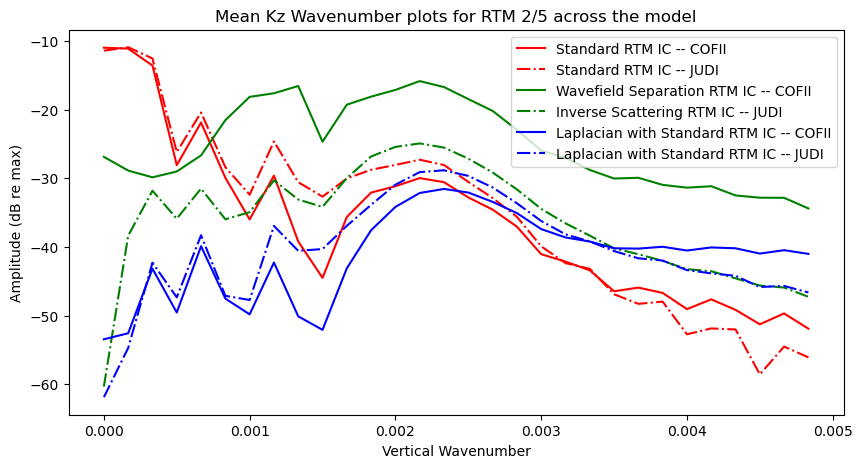

In [21]:
figure(figsize=(10,5))
plot(fz, reverse(mean(db_rtm1_COFII[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="solid",color="red",label="Standard RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm1_JUDI[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="-.",color="red",label="Standard RTM IC -- JUDI");
plot(fz, reverse(mean(db_rtm2_COFII[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="solid",color="green",label="Wavefield Separation RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm2_JUDI[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="-.",color="green",label="Inverse Scattering RTM IC -- JUDI");
plot(fz, reverse(mean(db_rtm1L_COFII[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="solid",color="blue",label="Laplacian with Standard RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm1L_JUDI[:,x2-nmean:x2+nmean],dims=2),dims=1),
    linestyle="-.",color="blue",label="Laplacian with Standard RTM IC -- JUDI");
title("Mean Kz Wavenumber plots for RTM 1/2 across the model")
xlabel("Vertical Wavenumber"); ylabel("Amplitude (dB re max)")
legend()

figure(figsize=(10,5))
plot(fz, reverse(mean(db_rtm1_COFII[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="solid",color="red",label="Standard RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm1_JUDI[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="-.",color="red",label="Standard RTM IC -- JUDI");
plot(fz, reverse(mean(db_rtm2_COFII[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="solid",color="green",label="Wavefield Separation RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm2_JUDI[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="-.",color="green",label="Inverse Scattering RTM IC -- JUDI");
plot(fz, reverse(mean(db_rtm1L_COFII[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="solid",color="blue",label="Laplacian with Standard RTM IC -- COFII");
plot(fz, reverse(mean(db_rtm1L_JUDI[:,x3-nmean:x3+nmean],dims=2),dims=1),
    linestyle="-.",color="blue",label="Laplacian with Standard RTM IC -- JUDI");
title("Mean Kz Wavenumber plots for RTM 2/5 across the model")
xlabel("Vertical Wavenumber"); ylabel("Amplitude (dB re max)")
legend()

nothing